In [1]:
import torch
import numpy as np
import torch.nn as nn
import dynamic_selection as ds
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from dynamic_selection.utils import Flatten
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection

In [2]:
# Load dataset.
mnist_dataset = MNIST('/tmp/mnist/', download=True, train=True,
                      transform=transforms.Compose([transforms.ToTensor(), Flatten()]))
test_dataset = MNIST('/tmp/mnist/', download=True, train=False,
                     transform=transforms.Compose([transforms.ToTensor(), Flatten()]))
d_in = 784
d_out = 10

# Split into train/val.
np.random.seed(0)
val_inds = np.sort(np.random.choice(len(mnist_dataset), size=10000, replace=False))
train_inds = np.setdiff1d(np.arange(len(mnist_dataset)), val_inds)
train_dataset = torch.utils.data.Subset(mnist_dataset, train_inds)
val_dataset = torch.utils.data.Subset(mnist_dataset, val_inds)

In [3]:
# Prepare dataloaders.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1024, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1024, pin_memory=True, num_workers=2)

In [4]:
# Prepare feature groups.
feature_groups = np.zeros((28, 28), dtype=int)
index = 0
for i in range(14):
    for j in range(14):
        feature_groups[(2 * i):(2 * i + 2), (2 * j):(2 * j + 2)] = index
        index += 1
feature_groups = feature_groups.flatten()

# Prepare group matrix.
group_matrix = np.zeros((196, 784))
for group in range(196):
    inds = np.where(feature_groups == group)[0]
    group_matrix[group, inds] = 1
num_groups = 196

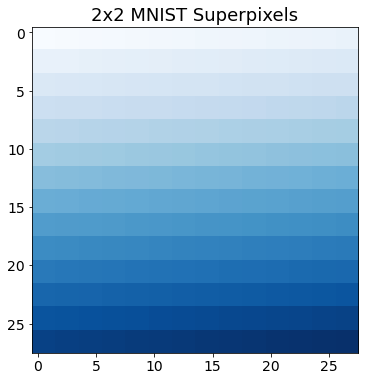

In [5]:
# Plot feature groups.
plt.figure(figsize=(6, 6))
plt.imshow(feature_groups.reshape(28, 28), cmap='Blues')
plt.title('2x2 MNIST Superpixels', fontsize=18)
plt.tick_params(labelsize=14)
plt.show()

In [6]:
# Prepare networks.
hidden = 512
dropout = 0.3

predictor = nn.Sequential(
    nn.Linear(d_in + num_groups, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out))

selector = nn.Sequential(
    nn.Linear(d_in + num_groups, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, num_groups))

In [7]:
# Pretrain predictor
mask_layer = ds.utils.MaskLayerGrouped(group_matrix=torch.tensor(group_matrix).float(), append=True)
pretrain = MaskingPretrainer(predictor, mask_layer).cuda()
pretrain.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

--------Epoch 1--------
Val loss = 0.6283

--------Epoch 2--------
Val loss = 0.5232

--------Epoch 3--------
Val loss = 0.4727

--------Epoch 4--------
Val loss = 0.4837

--------Epoch 5--------
Val loss = 0.4756

--------Epoch 6--------
Val loss = 0.4111

--------Epoch 7--------
Val loss = 0.4223

--------Epoch 8--------
Val loss = 0.4136

--------Epoch 9--------
Val loss = 0.4140

Epoch 00009: reducing learning rate of group 0 to 2.0000e-04.
--------Epoch 10--------
Val loss = 0.3579

--------Epoch 11--------
Val loss = 0.3844

--------Epoch 12--------
Val loss = 0.3678

--------Epoch 13--------
Val loss = 0.3524

--------Epoch 14--------
Val loss = 0.3548

--------Epoch 15--------
Val loss = 0.3599

--------Epoch 16--------
Val loss = 0.3449

--------Epoch 17--------
Val loss = 0.3525

--------Epoch 18--------
Val loss = 0.3496

--------Epoch 19--------
Val loss = 0.3553

Epoch 00019: reducing learning rate of group 0 to 4.0000e-05.
--------Epoch 20--------
Val loss = 0.3464

Stopp

In [8]:
# Train selector and predictor jointly.
gdfs = GreedyDynamicSelection(selector, predictor, mask_layer).cuda()
gdfs.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=250,
    max_features=10,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

Starting training with temp = 1.0000

--------Epoch 1 (1 total)--------
Val loss = 0.6577, Zero-temp loss = 1.1197

--------Epoch 2 (2 total)--------
Val loss = 0.5652, Zero-temp loss = 1.1139

--------Epoch 3 (3 total)--------
Val loss = 0.4923, Zero-temp loss = 1.0385

--------Epoch 4 (4 total)--------
Val loss = 0.4615, Zero-temp loss = 1.0625

--------Epoch 5 (5 total)--------
Val loss = 0.4232, Zero-temp loss = 1.0570

--------Epoch 6 (6 total)--------
Val loss = 0.3905, Zero-temp loss = 1.0336

--------Epoch 7 (7 total)--------
Val loss = 0.3768, Zero-temp loss = 1.0456

--------Epoch 8 (8 total)--------
Val loss = 0.3654, Zero-temp loss = 1.0658

--------Epoch 9 (9 total)--------
Val loss = 0.3477, Zero-temp loss = 1.0823

--------Epoch 10 (10 total)--------
Val loss = 0.3393, Zero-temp loss = 1.0460

--------Epoch 11 (11 total)--------
Val loss = 0.3325, Zero-temp loss = 1.1118

--------Epoch 12 (12 total)--------
Val loss = 0.3147, Zero-temp loss = 1.0654

--------Epoch 13 (13

# Evaluate performance

In [9]:
# Setup.
num_features = range(1, 11)
acc_list = []
acc_metric = Accuracy(task='multiclass', num_classes=10)

# Evaluate.
for num in num_features:
    acc = gdfs.evaluate(test_loader, num, acc_metric)
    acc_list.append(acc)
    print(f'Num = {num}, Acc = {100*acc:.2f}')

Num = 1, Acc = 37.07
Num = 2, Acc = 57.76
Num = 3, Acc = 73.20
Num = 4, Acc = 82.52
Num = 5, Acc = 87.93
Num = 6, Acc = 90.74
Num = 7, Acc = 92.60
Num = 8, Acc = 93.81
Num = 9, Acc = 94.61
Num = 10, Acc = 95.32


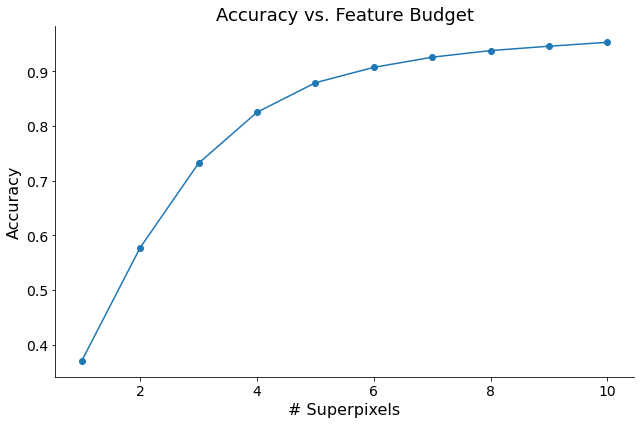

In [10]:
# Plot results
plt.figure(figsize=(9, 6))

# Accuracy
plt.plot(num_features, acc_list, marker='o')
plt.xlabel('# Superpixels', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

# Plot frequent selections

In [11]:
# Generate selections for 10 superpixels
num_features = 10
x, y = ds.data.get_xy(test_dataset)
pred, x_masked, m = gdfs(x.cuda(), max_features=num_features)

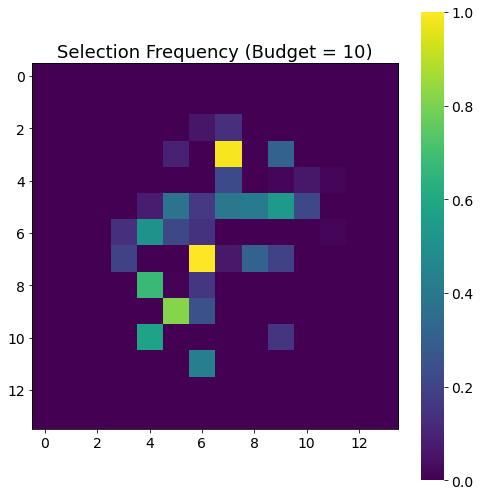

In [12]:
# Plot selection frequency.
plt.figure(figsize=(7, 7))

plt.imshow(m.mean(dim=0).cpu().data.numpy().reshape(14, 14))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.outline.set_visible(False)
plt.tick_params(labelsize=14)
plt.title('Selection Frequency (Budget = 10)', fontsize=18)

plt.tight_layout()
plt.show()